## Neural Style Transfer

In dieser Aufgabe geht es darum, *Neural Style Transfer* einmal selbst auszuprobieren und zu testen, was passiert, wenn man

- die Parameter des Style-Losses (ausgewählte Layer und Gewichtungen),
- die Parameter des Content-Losses 

anpasst.

### Zutaten

Als Ausgangspunkt verwenden wir

- ein vortrainiertes VGG19,
- ein Bild der Fachhochschule Südwestfalen, und
- das Gemälde *De Sterrennacht* (Sternennacht) von Vincent van Gogh.

Auch hier können Sie mit eigenen Bildern oder anderen vortrainierten Modellen experimentieren.

Der folgende Code entspricht weitgehend dem Beispiel zum Buch, enthält aber ein paar Aktualisierungen.

In [21]:
from torchvision.models import vgg19, VGG19_Weights
from torch.autograd import Variable
from collections import OrderedDict
from functools import reduce
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.transforms as transforms
from PIL import Image
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm, trange

In [22]:
image_size = 512
is_cuda = torch.cuda.is_available()

preprocessing = transforms.Compose([transforms.Resize(image_size),
                           transforms.ToTensor(),
                           transforms.Lambda(lambda x: x[torch.LongTensor([2,1,0])]), 
                           transforms.Normalize(mean=[0.40760392, 0.45795686, 0.48501961], 
                                                std=[1,1,1]),
                           transforms.Lambda(lambda x: x.mul_(255)),
                          ])
processing = transforms.Compose([transforms.Lambda(lambda x: x.mul_(1./255)),
                           transforms.Normalize(mean=[-0.40760392, -0.45795686, -0.48501961], 
                                                std=[1,1,1]),
                           transforms.Lambda(lambda x: x[torch.LongTensor([2,1,0])]), 
                           ])
postprocess = transforms.Compose([transforms.ToPILImage()])

def postprocess_b(tensor): 
    t = processing(tensor)
    t[t>1] = 1    
    t[t<0] = 0
    img = postprocess(t)
    return img

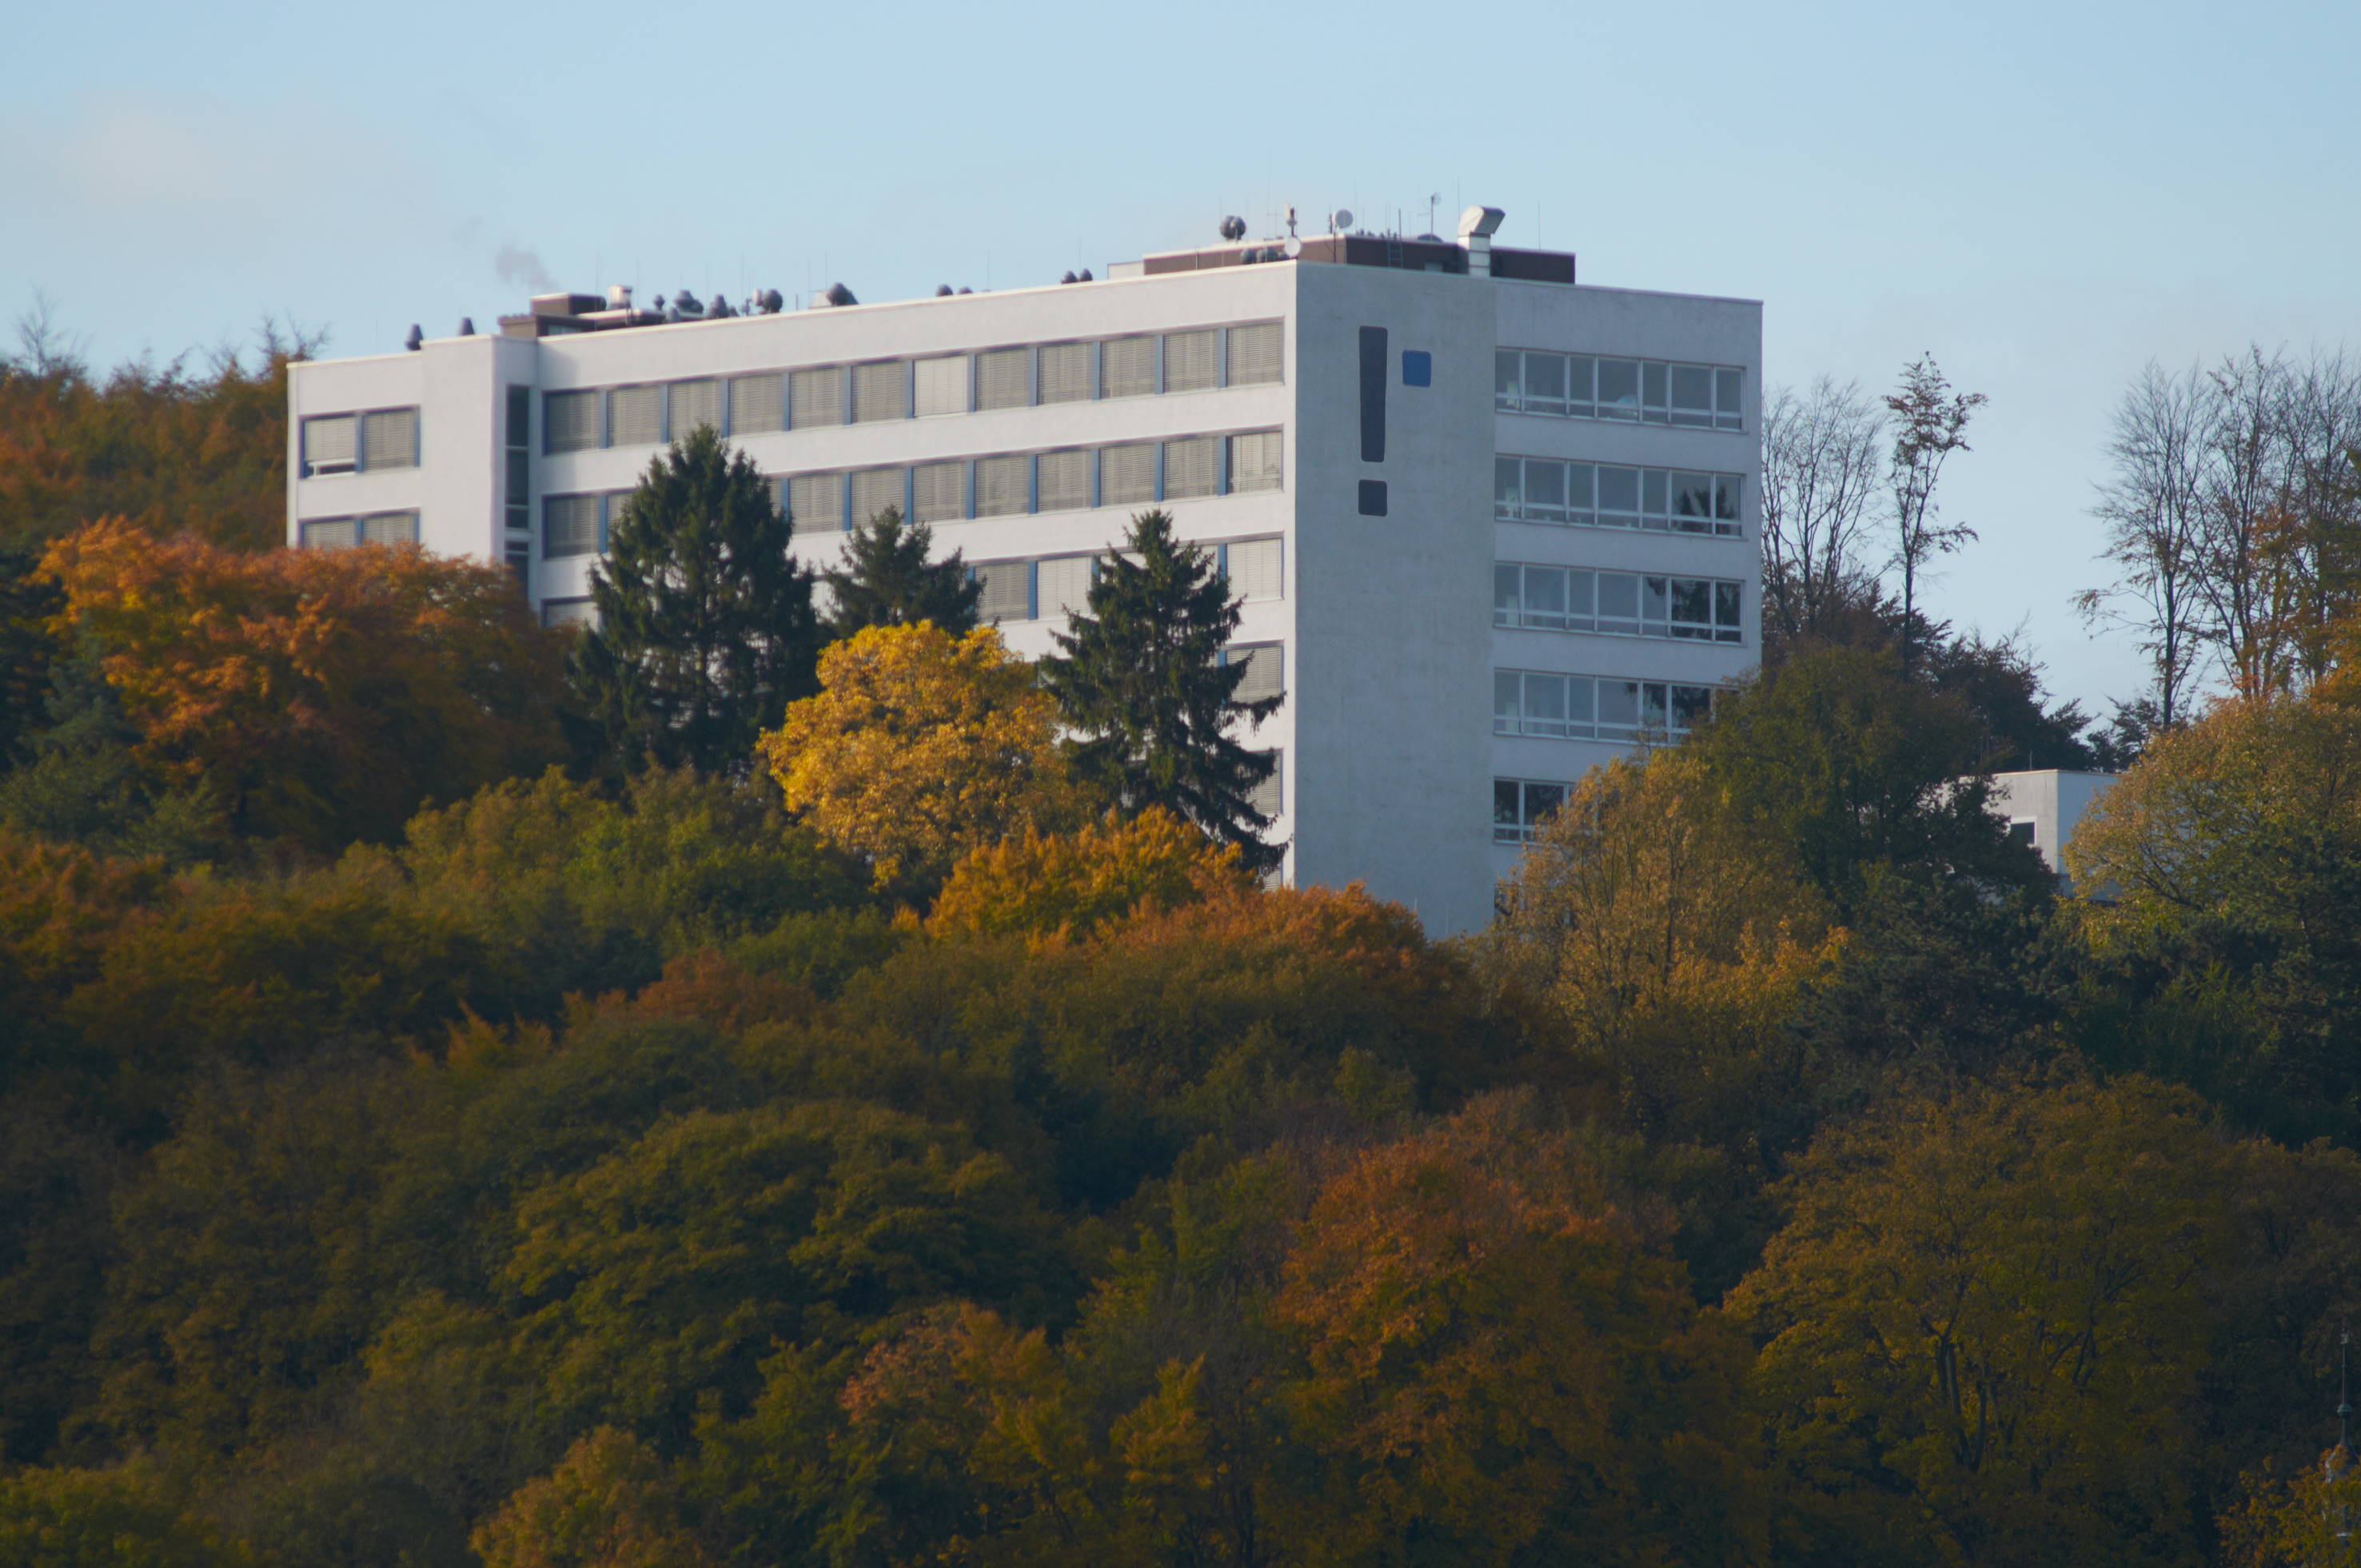

In [23]:
from IPython.display import Image as IPImage
IPImage('content/dab21-fh-swf-iserlohn.jpg')

In [24]:
def loader(image_name):
    image = Image.open(image_name)
    image = Variable(preprocessing(image))
    # fake batch dimension required to fit network's input dimensions
    image = image.unsqueeze(0)
    return image

### Auswertung der Layer

Während des Optimierungsvorgangs möchten wir auf die Ausgaben einzelner Layer zugreifen. Dazu wird an den entsprechenden Layern mit der Methode `register_forward_hook()` eine Funktion registriert, die Ausgabewerte "mitschneidet". 

In [25]:
class LayerActivations():
    features=[]
    
    def __init__(self, model, layer_nums):
        
        self.hooks = []
        for layer_num in layer_nums:
            self.hooks.append(model[layer_num].register_forward_hook(self.hook_fn))
    
    def hook_fn(self, module, input, output):
        self.features.append(output)

    
    def remove(self):
        for hook in self.hooks:
            hook.remove()

In [26]:
def extract_layers(layers, img, model=None):
    la = LayerActivations(model,layers)
    #Clearing the cache 
    la.features = []
    out = model(img)
    la.remove()
    return la.features

In [27]:
class GramMatrix(nn.Module):
    
    def forward(self,input):
        b,c,h,w = input.size()
        features = input.view(b,c,h*w)
        gram_matrix =  torch.bmm(features,features.transpose(1,2))
        gram_matrix.div_(h*w)
        return gram_matrix
   

In [28]:
class StyleLoss(nn.Module):
    
    def forward(self,inputs,targets):
        out = nn.MSELoss()(GramMatrix()(inputs),targets)
        return (out)

### Laden eines Modells

Wir laden hier für die Featureextraktion ein vortrainiertes VGG19. Dieses Modell soll nicht trainiert werden, daher wird die Gradientenberechnung deaktiviert.

In [29]:
# temporary fix cert issue

import http
import ssl
import urllib.request

class NoVerifyHTTPSHandler(urllib.request.HTTPSHandler):
    def __init__(self):
        urllib.request.HTTPSHandler.__init__(self)

    def https_open(self, req):
        return self.do_open(self.getConnection, req)

    def getConnection(self, host, timeout=300):
        return http.client.HTTPSConnection(host, context=ssl._create_unverified_context())

opener = urllib.request.build_opener(NoVerifyHTTPSHandler())
urllib.request.install_opener(opener)

In [30]:
model = vgg19(weights=VGG19_Weights.DEFAULT).features
for param in model.parameters():
    param.requires_grad = False

In [31]:
model

Sequential(
  (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (1): ReLU(inplace=True)
  (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (3): ReLU(inplace=True)
  (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (6): ReLU(inplace=True)
  (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (8): ReLU(inplace=True)
  (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (11): ReLU(inplace=True)
  (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (13): ReLU(inplace=True)
  (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (15): ReLU(inplace=True)
  (16): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (17): ReLU(inplace=True)
  (18): MaxPoo

### Style-Transfer durch Optimierung des Bildes

In der folgenden Funktion finden Sie einige Parameter, etwa die ausgewählten Layer und Gewichte für die beiden Verlustfunktionen.

Eine Besonderheit ist der verwendete Optimizer `optim.LBFGS`.  Dieser berechnet eine Näherung der Hesse-Matrix der Verlustfunktion (so etwas wie die zweite Ableitung einer Funktion mehrerer Variablen) und muss die Funktion dazu wiederholt auswerten. Daher erwartet die Funktion `optimizer.step(closure)` als Parameter eine Funktion ("Closure"), die die Verlustfunktion berechnet.

In [32]:
def style_transfer(style_image, content_image, maximum_iterations=1000, model=model):

    if is_cuda:
        style_image = style_image.cuda()
        content_image = content_image.cuda()
        model = model.cuda()
    
    ### Parameters to experment with 
    style_layers = [1,6,11,20,25]
    #style_layers = [6,11,20,25,28]
    content_layers = [-1, -5, -15]
    
    style_weights = [1e3/n**2 for n in [64, 64, 256, 512, 512]]
    content_weights = [1e1, 1e1, 1e1]
    ####
    
    loss_layers = style_layers + content_layers
    weights = style_weights + content_weights
    
    content_targets = extract_layers(content_layers, content_image, model=model)
    content_targets = [t.detach() for t in content_targets]
    
    style_targets = extract_layers(style_layers, style_image, model=model)
    style_targets = [GramMatrix()(t).detach() for t in style_targets]

    # this is a fixed target with content from the content image and style from the style image
    targets = style_targets + content_targets
    
    loss_fns = [StyleLoss()] * len(style_layers) + [nn.MSELoss()] * len(content_layers)
    if is_cuda:
        loss_fns = [fn.cuda() for fn in loss_fns]

    output_image = Variable(content_image.data.clone(),requires_grad=True)

    # run style transfer
    optimizer = optim.LBFGS([output_image]);
    
    with tqdm(total=maximum_iterations) as pbar:
        while pbar.n < pbar.total:
            def closure():
                optimizer.zero_grad()

                out = extract_layers(loss_layers, output_image, model=model)
                layer_losses = [weights[a] * loss_fns[a](A, targets[a]) for a, A in enumerate(out)]
                loss = reduce(torch.add, layer_losses)
                loss.backward()
                pbar.update()
                pbar.set_postfix({'loss': loss.item()})

                return loss

            optimizer.step(closure)

    out_img_hr = postprocess_b(output_image.data[0].cpu().squeeze())

    plt.imshow(out_img_hr)
    ax = plt.gca()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    plt.gcf().set_size_inches(10, 10)
    plt.show()
    

In [46]:
!pip install --upgrade jupyter ipywidgets
!conda update jupyter ipywidgets
!jupyter nbextension enable --py widgetsnbextension
!pip install jupyter --upgrade


Looking in indexes: http://ubuntu-mirror.emea.zf-world.com/artifactory/api/pypi/pythonhosted_files-pypi-remote/simple

PackageNotInstalledError: Package is not installed in prefix.
  prefix: /home/z183458/anaconda3/envs/pytorchgpu
  package name: jupyter


usage: jupyter [-h] [--version] [--config-dir] [--data-dir] [--runtime-dir]
               [--paths] [--json] [--debug]
               [subcommand]

Jupyter: Interactive Computing

positional arguments:
  subcommand     the subcommand to launch

options:
  -h, --help     show this help message and exit
  --version      show the versions of core jupyter packages and exit
  --config-dir   show Jupyter config dir
  --data-dir     show Jupyter data dir
  --runtime-dir  show Jupyter runtime dir
  --paths        show all Jupyter paths. Add --json for machine-readable
                 format.
  --json         output paths as machine-readable json
  --debug        output debug information about paths

Available subcommands: console dejavu ev

In [50]:
!jupyter nbextension enable --py widgetsnbextension


usage: jupyter [-h] [--version] [--config-dir] [--data-dir] [--runtime-dir]
               [--paths] [--json] [--debug]
               [subcommand]

Jupyter: Interactive Computing

positional arguments:
  subcommand     the subcommand to launch

options:
  -h, --help     show this help message and exit
  --version      show the versions of core jupyter packages and exit
  --config-dir   show Jupyter config dir
  --data-dir     show Jupyter data dir
  --runtime-dir  show Jupyter runtime dir
  --paths        show all Jupyter paths. Add --json for machine-readable
                 format.
  --json         output paths as machine-readable json
  --debug        output debug information about paths

Available subcommands: console dejavu events execute kernel kernelspec lab
labextension labhub migrate nbconvert notebook qtconsole run server
troubleshoot trust

Jupyter command `jupyter-nbextension` not found.


In [54]:
# FIX import error
from tqdm import tqdm

style_image = loader("style/starry_night.jpg")
content_image = loader("content/person.jpg")

style_transfer(style_image, content_image)


### Weitere Experimente

Probieren Sie den Neural Style Transfer mit anderen Bildern und anderen Parametern.